# LeNet-300-100: Learning Rate Decay, warmup & Scheduler

Experiments with LeNet-300-100 Dense neural network on MNIST dataset by using different _Learning Rate scheduler_, _decays_ and _warmup_.

In [122]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal

import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.4.1


In [3]:
batch_size = 64
num_classes = 10
num_epochs = 100

In [4]:
# Data preprocessing and cleadning:
# input image dimensions
img_rows, img_cols = 28, 28

# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (28, 28, 1)



In [6]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [7]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [9]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (60000, 784), y_train.shape = (60000, 10)
X_test.shape = (10000, 784), y_test.shape = (10000, 10)


### Prepare MNIST dataset for TensorFlow _GradientTape_ training:

In [10]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [11]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [12]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [13]:
# Choose loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam(lr = 0.0012)

In [14]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [15]:
def lenet300():
    """
    Define LeNet-300-100 dense neural network
    """
    
    model = Sequential()
    
    model.add(InputLayer(input_shape=(784, )))
    
    model.add(Flatten())
    
    model.add(
        Dense(
            units = 300, activation='relu',
            kernel_initializer=tf.initializers.GlorotUniform())
    )
    
    # model.add(Dropout(0.2))
    
    model.add(
        Dense(
            units = 100, activation='relu',
            kernel_initializer=tf.initializers.GlorotUniform())
    )
    
    # model.add(Dropout(0.1))
    
    model.add(
        Dense(units = num_classes, activation='softmax')
    )
    
    
    return model


In [45]:
# Initialize a LeNet-300-100 model-
model = lenet300()

### Constant Learning Rate:

Constant learning rate is the default learning rate schedule in SGD optimizer in Keras. Momentum and decay rate are both set to zero by default. It is tricky to choose the right learning rate. By experimenting with range of learning rates in author's example, lr = 0.1 shows a relatively good performance to start with. This can serve as a baseline for us to experiment with different learning rate strategies.

[Refer](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1) and [GitHub code](https://github.com/sukilau/Ziff-deep-learning/blob/master/3-CIFAR10-lrate/CIFAR10-lrate.ipynb)

In [79]:
# Constant Learning Rate-
optimizer = tf.keras.optimizers.SGD(lr = 0.1, momentum = 0.0, decay = 0.0, nesterov = False)

### Time-Based Decay Learning Rate:

The mathematical form of time-based decay is: $lr = \frac{lr_0}{1 + k \cdot t}$ where

- 'lr' & 'k' are hyperparameters
- 't' is the iteration number

Looking into the source code of Keras, the SGD optimizer takes 'decay' and 'lr' arguments and updates the learning rate by a decreasing factor in each epoch as follows-

lr = lr * (1. / (1. + self.decay * self.iterations))

In [125]:
# Time-Based Decay Learning Rate-
optimizer = tf.keras.optimizers.SGD(lr = 0.1, momentum = 0.0, decay = 1e-3, nesterov = False)

In [116]:
# Specify parameters for SGD optimizer-
lr = 0.1
decay = 1e-3
iterations = 0

In [117]:
# Python list to contain updated learning rates-
lr_vals = [0.1]

In [118]:
for epoch in range(20):
    iterations += 938
    
    # Keras code for SGD updates the LR by a decreasing factor in each epoch-
    lr *= (1 / (1 + decay * iterations))
    
    lr_vals.append(lr)

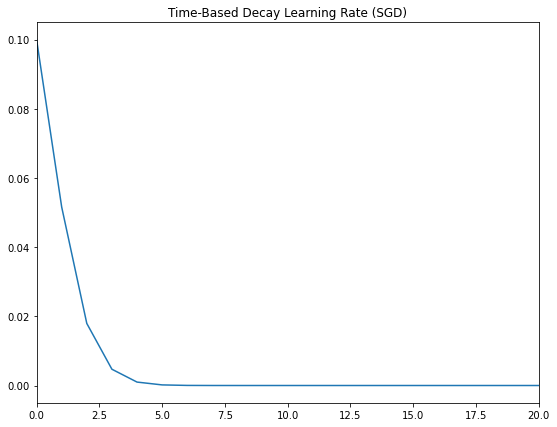

In [121]:
# Visualize time-based decay lr-
plt.figure(figsize = (9, 7))

plt.plot(lr_vals)
plt.title("Time-Based Decay Learning Rate (SGD)")
plt.xlim(0, 20)
plt.show()

### SGD _momentum_:

__Momentum__ is another argument in SGD optimizer which we can be tweaked to hopefully achieve faster convergence.

Unlike classical SGD, _momentum_ method helps the parameter vector to build up velocity in any direction with constant gradient descent so as to prevent oscillations. A typical choice of momentum is between 0.5 to 0.9.


### SGD _nesterov_:
SGD optimizer also has an argument called __nesterov__ which is set to false by default. __Nesterov momentum is a different version of the momentum method which has a stronger theoretical convergence guarantees for convex functions__. _In practice, it works slightly better than the standard momentum method._

In [142]:
# In Keras, time-based decay can be implemented by setting the initial learning rate, decay rate & momentum parameters in the SGD optimizer-
learning_rate = 0.1
decay_rate = learning_rate / num_epochs
momentum = 0.8

print(f"\nFor an initial learning rate of {learning_rate} & number of epochs = {num_epochs}, decay rate = {decay_rate}\n")

optimizer = tf.keras.optimizers.SGD(lr = learning_rate, momentum = momentum, decay = decay_rate, nesterov = False)


For an initial learning rate of 0.1 & number of epochs = 100, decay rate = 0.001



### Step Decay:

Step decay schedule drops the learning rate by a factor every few epochs. Mathematically, step decay can be represented as:
$lr = lr_0 \times drop^{\lfloor\frac{epoch}{epochs\, drop}\rfloor}$

Or, in code as ```lr = lr0 * drop^floor(epoch / epochs_drop)```

A typical way is to to drop the learning rate by half every 10 epochs. To implement this in Keras, we can define a step decay function and use [LearningRateScheduler](https://keras.io/callbacks/#learningratescheduler) callback to take the step decay function as argument and return the updated learning rates for use in SGD optimizer.

In [18]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    
    return lrate


In [21]:
lrate = LearningRateScheduler(step_decay)

As a digression, a [callback](https://keras.io/callbacks/#callback) is a set of functions to be applied at given stages of the training procedure. We can use callbacks to get a view on internal states and statistics of the model during training.

In the following example, we create a custom callback by extending the base class ```keras.callbacks.Callback``` to record loss history and learning rate during the training procedure.

In [25]:
class LossHistory(tf.keras.callbacks.Callback):
    '''
    A custom callback to record loss history and learning rate
    during model training.
    '''
    
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        

Putting everything together, we can pass a callback list consisting of ```LearningRateScheduler``` callback and our custom callback to train/fit the model. We can then visualize the learning rate schedule and the loss history by accessing ```loss_history.lr``` and ```loss_history.losses```.

In [30]:
# define SGD optimizer
momentum = 0.5
sgd = tf.keras.optimizers.SGD(lr = 0.0, momentum = momentum, decay = 0.0, nesterov = False) 

# Compile model-
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = sgd,
    metrics=['accuracy']
)


In [31]:
# Custom callback to record loss history & learning rate during training-
loss_history = LossHistory()

# 'LearningRateScheduler' callback-
lrate = LearningRateScheduler(step_decay)

# callback list-
callbacks_list = [loss_history, lrate]

history_step_decay = model.fit(
    x = X_train, y = y_train, 
    validation_data=(X_test, y_test),
    epochs = 15, batch_size = batch_size, 
    callbacks = callbacks_list, verbose = 2)

Epoch 1/15
938/938 - 6s - loss: 0.2569 - accuracy: 0.9239 - val_loss: 0.1470 - val_accuracy: 0.9556
Epoch 2/15
938/938 - 5s - loss: 0.1039 - accuracy: 0.9690 - val_loss: 0.1069 - val_accuracy: 0.9675
Epoch 3/15
938/938 - 5s - loss: 0.0698 - accuracy: 0.9785 - val_loss: 0.0852 - val_accuracy: 0.9726
Epoch 4/15
938/938 - 5s - loss: 0.0507 - accuracy: 0.9843 - val_loss: 0.0734 - val_accuracy: 0.9775
Epoch 5/15
938/938 - 5s - loss: 0.0379 - accuracy: 0.9882 - val_loss: 0.0723 - val_accuracy: 0.9778
Epoch 6/15
938/938 - 5s - loss: 0.0284 - accuracy: 0.9917 - val_loss: 0.0753 - val_accuracy: 0.9768
Epoch 7/15
938/938 - 4s - loss: 0.0214 - accuracy: 0.9934 - val_loss: 0.0670 - val_accuracy: 0.9785
Epoch 8/15
938/938 - 5s - loss: 0.0154 - accuracy: 0.9955 - val_loss: 0.0607 - val_accuracy: 0.9829
Epoch 9/15
938/938 - 5s - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.0689 - val_accuracy: 0.9796
Epoch 10/15
938/938 - 5s - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.0613 - val_accuracy: 0.9820

In [32]:
history_step_decay.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

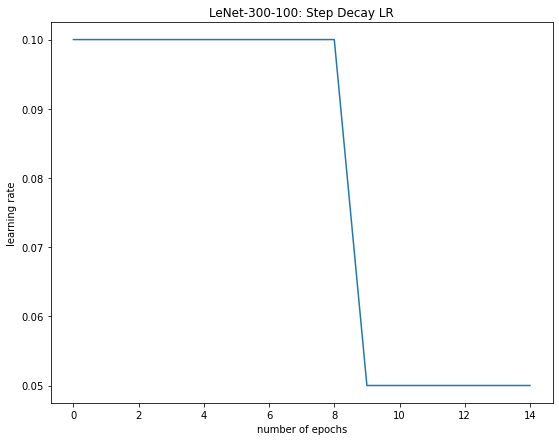

In [34]:
# Visualize learning rate decay-

plt.figure(figsize = (9, 7))
plt.plot(history_step_decay.history['lr'])

plt.xlabel("number of epochs")
plt.ylabel("learning rate")
plt.title("LeNet-300-100: Step Decay LR")
plt.show()

### Step Decay: Learning Rate Schedule

For MNIST, training dataset has 60K images and batch size = 64. Therefore, number of training steps in one epoch = 937.5 = 938. So, 12 epochs has 11256 training steps/iterations.

According to these calculations, the learning rate schedule is as follows-

1. For the first 11256 training steps (or, 12 epochs), use a learning rate of 0.1

1. For the next 4690 training steps (or, 5 epochs), use a learning rate of 0.01

1. For any remaing training steps, use a learning rate of 0.001

For explanation of this, refer to [stack overflow answer](https://stackoverflow.com/questions/60801746/tensorflow-2-0-learning-rate-scheduler-with-tf-gradienttape), [tensorflow piecewise constant decay tutorial](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay) and [tensorflow customization](https://stackoverflow.com/questions/60801746/tensorflow-2-0-learning-rate-scheduler-with-tf-gradienttape)

In [90]:
model = lenet300()

In [91]:
boundaries = [11255, 15946]
values = [0.1, 0.01, 0.001]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0012)
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn, momentum = 0.9, decay = 0.0, nesterov = False) 

### Exponential Decay:

Another common learning rate schedule is _exponential decay_. It has the mathematical form of $lr = lr_0 \times e^{-kt}$ where 'lr' and 'k' are hyperparameters and 't' is the iteration number. It can be denoted in code as ```lr = lr0 * e^(−kt)```.

Similarly, we can implement this by defining an exponential decay function and pass it to ```LearningRateScheduler```. In fact, __any custom decay schedule can be implemented in Keras using this approach__. The only difference is to define a different custom decay function.

[tensorflow exponential decay reference page](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay)

In [107]:
model = lenet300()

In [108]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * exp(-k*t)
    
    return lrate


In [109]:
lrate = LearningRateScheduler(exp_decay)

In [111]:
# define SGD optimizer
momentum = 0.8
optimizer = tf.keras.optimizers.SGD(lr = 0.0, momentum = momentum, decay = 0.0, nesterov = False)

# Compile model-
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = sgd,
    metrics = ['accuracy']
)


In [113]:
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)
callbacks_list_ = [loss_history_, lrate_]


In [114]:
# Train model-
history_exp_decay = model.fit(
    x = X_train, y = y_train, 
    validation_data=(X_test, y_test), 
    epochs = 15,  batch_size = batch_size,
    callbacks = callbacks_list_ 
)

Epoch 1/15
938/938 [==============================] - 9s 9ms/step - loss: 0.4439 - accuracy: 0.8738 - val_loss: 0.1389 - val_accuracy: 0.9582
lr: 0.09048374180359596
Epoch 2/15
938/938 [==============================] - 9s 9ms/step - loss: 0.1092 - accuracy: 0.9682 - val_loss: 0.0837 - val_accuracy: 0.9737
lr: 0.0818730753077982
Epoch 3/15
938/938 [==============================] - 8s 9ms/step - loss: 0.0672 - accuracy: 0.9791 - val_loss: 0.0819 - val_accuracy: 0.9731
lr: 0.0740818220681718
Epoch 4/15
938/938 [==============================] - 9s 9ms/step - loss: 0.0486 - accuracy: 0.9855 - val_loss: 0.0662 - val_accuracy: 0.9792
lr: 0.06703200460356394
Epoch 5/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0336 - accuracy: 0.9908 - val_loss: 0.0671 - val_accuracy: 0.9771
lr: 0.06065306597126335
Epoch 6/15
938/938 [==============================] - 8s 9ms/step - loss: 0.0258 - accuracy: 0.9933 - val_loss: 0.0576 - val_accuracy: 0.9808
lr: 0.05488116360940264
Epoch 

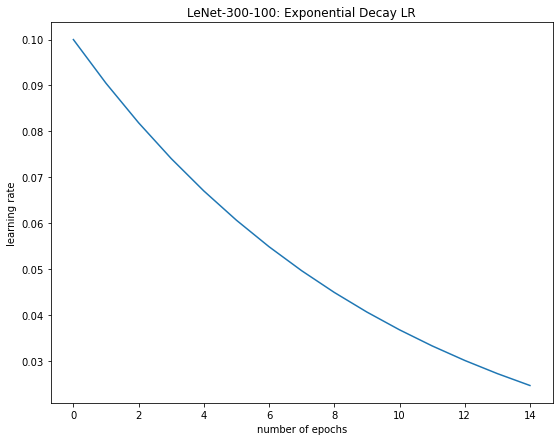

In [115]:
# Visualize learning rate decay-

plt.figure(figsize = (9, 7))
plt.plot(history_exp_decay.history['lr'])

plt.xlabel("number of epochs")
plt.ylabel("learning rate")
plt.title("LeNet-300-100: Exponential Decay LR")
plt.show()

In [92]:
# Compile model-
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    # optimizer='adam',
    # optimizer=tf.keras.optimizers.Adam(lr = 0.0012),
    optimizer = optimizer,
    metrics=['accuracy']
)

In [93]:
# Get summary of defined neural network-
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_34 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_35 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Counting trainable and non-trainable weights. Also counts biases.

trainable_wts = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_wts = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print("\nNumber of training weights = {0} and non-trainabel weights = {1}\n".format(
    trainable_wts, non_trainable_wts
))
print("Total number of parameters = {0}\n".format(trainable_wts + non_trainable_wts))


Number of training weights = 266610 and non-trainabel weights = 0.0

Total number of parameters = 266610.0



In [94]:
# Instantiate a new neural network model & load weights for masks-
mask_model = lenet300()
mask_model.set_weights(model.get_weights())

In [95]:
# For each layer, for each weight which is 0, leave it, as is.
# And for weights which survive the pruning,reinitialize it to ONE (1)-
# for wts in mask_model_stripped.trainable_weights:
#    wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

# Assign each parameter to 1s-
for wts in mask_model.trainable_weights:
    wts.assign(tf.ones_like(wts))

In [96]:
# Count number of non-zero parameters in mask-
mask_sum_params = 0

for layer in mask_model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    mask_sum_params += loc_params
    print(f"layer.shape: {layer.shape} has {loc_params} parameters")

print("\nNumber of non-zero parameters in mask = {0}\n".format(mask_sum_params))

layer.shape: (784, 300) has 235200 parameters
layer.shape: (300,) has 300 parameters
layer.shape: (300, 100) has 30000 parameters
layer.shape: (100,) has 100 parameters
layer.shape: (100, 10) has 1000 parameters
layer.shape: (10,) has 10 parameters

Number of non-zero parameters in mask = 266610



In [63]:
# Count number of non-zero parameters in model-
orig_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    orig_params += loc_params
    print(f"layer.shape: {layer.shape} has {loc_params} parameters")

print("\nNumber of non-zero parameters in model = {0}\n".format(orig_params))

layer.shape: (784, 300) has 235200 parameters
layer.shape: (300,) has 0 parameters
layer.shape: (300, 100) has 30000 parameters
layer.shape: (100,) has 0 parameters
layer.shape: (100, 10) has 1000 parameters
layer.shape: (10,) has 0 parameters

Number of non-zero parameters in model = 266200



In [84]:
def count_nonzero_params(model):
    model_sum_params = 0
    
    for layer in model.trainable_weights:
        loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
        model_sum_params += loc_params
        
    return model_sum_params


In [65]:
# Sanity check-
count_nonzero_params(model)

266200

## Learning rate warmup:

Using a large learning rate may result in numerical instability especially at the very beginning of training where parameters are randomly initialized. The warmup strategy increases the learning rate from 0 to the initial learning rate linearly during the initial __N__ epochs or __m__ batches.

Even though Keras already came with the [LearningRateScheduler](https://keras.io/callbacks/#learningratescheduler) capable of updating the learning rate for each training epoch, in order to achieve finer updates for each batch, the following code is _how you can implement a custom Keras callback to do that_.


[reference](https://www.dlology.com/blog/bag-of-tricks-for-image-classification-with-convolutional-neural-networks-in-keras/)

In [127]:
model = lenet300()

In [131]:
# Compile model-
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.SGD(lr = 0.1, momentum = 0.8, decay = 0.0, nesterov = False),
    metrics=['accuracy']
)

In [132]:
class WarmUpLearningRateScheduler(tf.keras.callbacks.Callback):
    """
    Warmup learning rate scheduler
    """
    def __init__(self, warmup_batches, init_lr, verbose = 0):
        """
        Constructor for warmup learning rate scheduler

        Arguments:
            1.) warmup_batches {int} -- Number of batches/steps for warmup.
            2.) init_lr {float} -- Learning rate after warmup.

        Keyword Arguments:
            verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpLearningRateScheduler, self).__init__()
        self.warmup_batches = warmup_batches
        self.init_lr = init_lr
        self.verbose = verbose
        self.batch_count = 0
        self.learning_rates = []

        
    def on_batch_end(self, batch, logs = None):
        self.batch_count = self.batch_count + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)
        
        return None

    
    def on_batch_begin(self, batch, logs = None):
        if self.batch_count <= self.warmup_batches:
            lr = self.batch_count*self.init_lr/self.warmup_batches
            K.set_value(self.model.optimizer.lr, lr)
            
            if self.verbose > 0:
                print(f"batch = {self.batch_count + 1}: WarmUpLearningRateScheduler setting learning rate to {lr:.6f}")
                """
                print('\nBatch %05d: WarmUpLearningRateScheduler setting learning '
                      'rate to %s.' % (self.batch_count + 1, lr))
                """
        
        return None
    


In [133]:
# Number of warmup epochs-
warmup_epoch = 5

# Compute the number of warmup batches-
warmup_batches = warmup_epoch * X_train.shape[0] / batch_size

print(f"number of warmup epochs = {warmup_epoch} & number of warmup batches = {warmup_batches}")

number of warmup epochs = 5 & number of warmup batches = 4687.5


In [134]:
# Create the Learning rate scheduler.
warm_up_lr = WarmUpLearningRateScheduler(warmup_batches, init_lr = 0.01)

# init_lr -> learning rate AFTER warmup

In [136]:
history_lr_warmup = model.fit(
    x = X_train, y = y_train,
    epochs = 15, batch_size = batch_size,
    validation_data = (X_test, y_test),
    callbacks = [warm_up_lr]
)

Epoch 1/15
938/938 [==============================] - 9s 9ms/step - loss: 2.0449 - accuracy: 0.3135 - val_loss: 0.5604 - val_accuracy: 0.8665
Epoch 2/15
938/938 [==============================] - 8s 9ms/step - loss: 0.4727 - accuracy: 0.8773 - val_loss: 0.2990 - val_accuracy: 0.9172
Epoch 3/15
938/938 [==============================] - 9s 9ms/step - loss: 0.2985 - accuracy: 0.9157 - val_loss: 0.2333 - val_accuracy: 0.9321
Epoch 4/15
938/938 [==============================] - 9s 9ms/step - loss: 0.2218 - accuracy: 0.9368 - val_loss: 0.1830 - val_accuracy: 0.9461
Epoch 5/15
938/938 [==============================] - 9s 10ms/step - loss: 0.1723 - accuracy: 0.9501 - val_loss: 0.1471 - val_accuracy: 0.9560
Epoch 6/15
938/938 [==============================] - 8s 9ms/step - loss: 0.1313 - accuracy: 0.9626 - val_loss: 0.1242 - val_accuracy: 0.9620
Epoch 7/15
938/938 [==============================] - 9s 9ms/step - loss: 0.1097 - accuracy: 0.9678 - val_loss: 0.1064 - val_accuracy: 0.9676
Epoch

In [138]:
history_lr_warmup.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

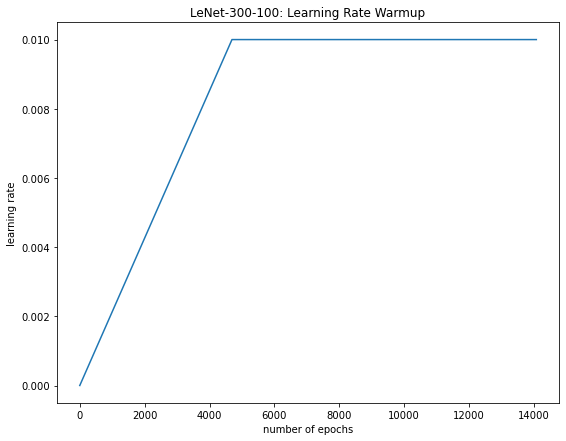

In [141]:
# Visualize learning rate warmup-

plt.figure(figsize = (9, 7))
plt.plot(warm_up_lr.learning_rates)

plt.xlabel("number of epochs")
plt.ylabel("learning rate")
plt.title("LeNet-300-100: Learning Rate Warmup")
plt.show()

### Train LeNet-300-100 model:

In [97]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 15

In [98]:
best_val_loss = 100
loc_patience = 0

In [150]:
@tf.function
def train_one_step(model, mask_model, optimizer, x, y):
    '''
    Function to compute one step of gradient descent optimization
    '''
    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_pred = model(x)

        # Compute loss-
        loss = loss_fn(y, y_pred)
            
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)
    # list

    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    for grad_layer, mask in zip(grads, mask_model.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

    # Compute accuracy-
    train_loss(loss)
    train_accuracy(y, y_pred)

    return None
    
    
@tf.function
def test_step(model, optimizer, data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

    return None


In [151]:
# Python3 dict to contain training metrics for Constant Learning Rate-
# history_constant_lr = {}

# Python3 dict to contain training metrics for Time-Based Decay Learning Rate-
# history_time_decay_lr = {}

# Python3 dict to contain training metrics for Step Decay Learning Rate-
# history_step_decay_lr = {}

# Python3 dict to contain training metrics for Learning Rate Warmpup and Step Decay-
history_warmup_and_decay_lr = {}

### To get the optimizer's current learning rate:

- If you directly extract the learning rate from the optimizer by using ```optimizer.lr``` or ```optimizer.learning_rate.numpy()```, it always shows the initial learning rate rather than the updated/decayed learning rate. Also, if you use a custom training loop, you cannot use callback!

- __The correct solution is to use:__

```optimizer._decayed_lr('float32').numpy()```

```print(optimizer._decayed_lr('float32').numpy())```

[GitHub answer URL](https://github.com/tensorflow/tensorflow/issues/39782)

In [ ]:
# Train model using 'GradientTape'-    
for epoch in range(num_epochs):
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
        
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
        
        
    for x, y in train_dataset:
        train_one_step(model, mask_model, optimizer, x, y)

    for x_t, y_t in test_dataset:
        test_step(model, optimizer, x_t, y_t)

    
    # template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    # print("\nCurrent step value: {0}, LR: {1:.6f}\n".format(optimizer.iterations.numpy(), optimizer.learning_rate(optimizer.iterations)))
    template = '\nEpoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}, LR: {5:.6f}, Current step value: {6}'

    
    print(template.format(epoch + 1, 
                          train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100,
                          # optimizer.learning_rate.numpy()
                          optimizer._decayed_lr('float32').numpy(),
                          optimizer.iterations.numpy()
                         )
         )
    
    # history_constant_lr[epoch + 1]
    history_step_decay_lr[epoch + 1] = {'loss': train_loss.result(), 'acc': train_accuracy.result() * 100, 'val_loss': test_loss.result(),
                                      'val_acc': test_accuracy.result() * 100, 'lr': optimizer._decayed_lr('float32').numpy(),
                                      'step_val': optimizer.iterations.numpy()
                                     }
    
    print(f"Total number of trainable parameters = {count_nonzero_params(model)}")

    # Code for manual Early Stopping:
    if (test_loss.result() < best_val_loss) and (np.abs(test_loss.result() - best_val_loss) >= minimum_delta):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = test_loss.result()
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
        print(f"Saving model with lowest val_loss = {test_loss.result()}\n")
        model.save_weights("LeNet300_best_val_loss.h5", overwrite = True)
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement

    

### Using learning rate _warmup_ and _step-decay_ with TensorFlow2:

[Warmup code](https://huggingface.co/transformers/_modules/transformers/optimization_tf.html#WarmUp) & [StackOverflow answer](https://stackoverflow.com/questions/63213252/using-learning-rate-schedule-and-learning-rate-warmup-with-tensorflow2). Also have a look into [GitHub](https://github.com/tensorflow/addons/issues/2086)

In [143]:
from typing import Callable, List, Optional, Union

In [144]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Applies a warmup schedule on a given learning rate decay schedule.

    Args:
        initial_learning_rate (:obj:`float`):
            The initial learning rate for the schedule after the warmup (so this will be the learning rate at the end
            of the warmup).
            
        decay_schedule_fn (:obj:`Callable`):
            The schedule function to apply after the warmup for the rest of training.
        
        warmup_steps (:obj:`int`):
            The number of steps for the warmup part of training.
        
        power (:obj:`float`, `optional`, defaults to 1):
            The power to use for the polynomial warmup (defaults is a linear warmup).
        
        name (:obj:`str`, `optional`):
            Optional name prefix for the returned tensors during the schedule.
    """

    def __init__(
        self,
        initial_learning_rate: float,
        decay_schedule_fn: Callable,
        warmup_steps: int,
        power: float = 1.0,
        name: str = None,
    ):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_schedule_fn = decay_schedule_fn
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:
            # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
            # learning rate will be `global_step/num_warmup_steps * init_lr`.
            global_step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            warmup_percent_done = global_step_float / warmup_steps_float
            warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
            return tf.cond(
                global_step_float < warmup_steps_float,
                lambda: warmup_learning_rate,
                lambda: self.decay_schedule_fn(step - self.warmup_steps),
                name=name,
            )

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_schedule_fn": self.decay_schedule_fn,
            "warmup_steps": self.warmup_steps,
            "power": self.power,
            "name": self.name,
        }
    
    

### Step decay learning rate "after" learning rate warmup:

__After 10 epochs or 9380 training steps__:

- for the next 11256 training steps or 12 epochs, use the learning rate = 0.1

- for the next 4690 training steps or 5 epochs, use the learning rate = 0.01

- for any remaining training steps, use the learning rate = 0.001

```
boundaries = [11255, 15946]
values = [0.1, 0.01, 0.001]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
```


In [146]:
warmup_shcedule = WarmUp(initial_learning_rate = 0.1, decay_schedule_fn = learning_rate_fn, warmup_steps = 9380)

In [147]:
optimizer = tf.keras.optimizers.SGD(learning_rate = warmup_shcedule, momentum = 0.9, decay = 0.0, nesterov = False)

In [148]:
# Initialize a new model-
model = lenet300()

In [149]:
# Compile model-
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = optimizer,
    metrics=['accuracy']
)

### Training loop for _Warmup schedule_ and _Step Decay_ of learning rate:

In [153]:
best_val_loss = 100

In [154]:
# Train model using 'GradientTape' and without early stopping criterion-
for epoch in range(30):
        
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
        
        
    for x, y in train_dataset:
        train_one_step(model, mask_model, optimizer, x, y)

    for x_t, y_t in test_dataset:
        test_step(model, optimizer, x_t, y_t)

    
    # template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    # print("\nCurrent step value: {0}, LR: {1:.6f}\n".format(optimizer.iterations.numpy(), optimizer.learning_rate(optimizer.iterations)))
    template = '\nEpoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}, LR: {5:.6f}, Current step value: {6}'

    
    print(template.format(epoch + 1, 
                          train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100,
                          # optimizer.learning_rate.numpy()
                          optimizer._decayed_lr('float32').numpy(),
                          optimizer.iterations.numpy()
                         )
         )
    
    history_warmup_and_decay_lr[epoch + 1] = {'loss': train_loss.result(), 'acc': train_accuracy.result() * 100, 'val_loss': test_loss.result(),
                                      'val_acc': test_accuracy.result() * 100, 'lr': optimizer._decayed_lr('float32').numpy(),
                                      'step_val': optimizer.iterations.numpy()
                                     }
    
    print(f"Total number of trainable parameters = {count_nonzero_params(model)}")

    
    if test_loss.result() < best_val_loss:
        print(f"Saving model with lowest val_loss = {test_loss.result()}\n")
        model.save_weights("LeNet300_best_val_loss.h5", overwrite = True)
        
    


Epoch 1, Loss: 0.7202, Accuracy: 79.7267, Test Loss: 0.2451, Test Accuracy: 92.760002, LR: 0.010000, Current step value: 938
Total number of trainable parameters = 266610
Saving model with lowest val_loss = 0.2451491802930832


Epoch 2, Loss: 0.1830, Accuracy: 94.5833, Test Loss: 0.1263, Test Accuracy: 96.160004, LR: 0.020000, Current step value: 1876
Total number of trainable parameters = 266610
Saving model with lowest val_loss = 0.12634992599487305


Epoch 3, Loss: 0.1132, Accuracy: 96.5233, Test Loss: 0.1018, Test Accuracy: 96.979996, LR: 0.030000, Current step value: 2814
Total number of trainable parameters = 266610
Saving model with lowest val_loss = 0.10179414600133896


Epoch 4, Loss: 0.0858, Accuracy: 97.3167, Test Loss: 0.1043, Test Accuracy: 96.820000, LR: 0.040000, Current step value: 3752
Total number of trainable parameters = 266610
Saving model with lowest val_loss = 0.10429243743419647


Epoch 5, Loss: 0.0748, Accuracy: 97.5950, Test Loss: 0.0965, Test Accuracy: 97.00

In [159]:
# Save Python3 dict for later analysis-
import pickle

# with open("LeNet300-history_constant_lr.pkl", "wb") as file:
# with open("LeNet300-time_based_decay_lr.pkl", "wb") as file:
with open("LeNet300-warmup_and_stepdecay_lr.pkl", "wb") as file:
    # pickle.dump(history_constant_lr, file)
    # pickle.dump(history_time_decay_lr, file)
    pickle.dump(history_warmup_and_decay_lr, file)

### Visualize training metrics:

In [86]:
plot_acc = {}
plot_val_acc = {}

In [87]:
for epoch in history_constant_lr.keys():
    plot_acc[epoch] = history_constant_lr[epoch]['acc']
    plot_val_acc[epoch] = history_constant_lr[epoch]['val_acc']

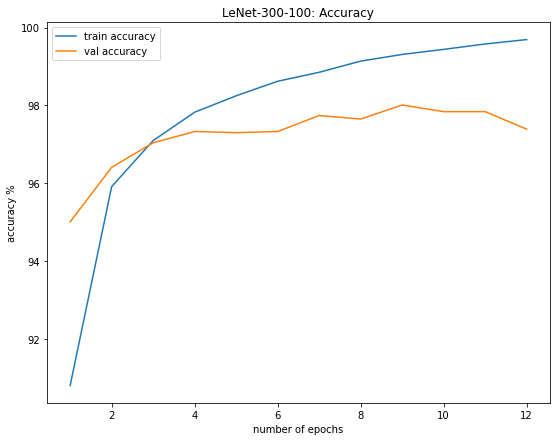

In [88]:
# Visualize accuracies-
plt.figure(figsize = (9, 7))

plt.plot(list(plot_acc.keys()), list(plot_acc.values()), label = 'train accuracy')
plt.plot(list(plot_val_acc.keys()), list(plot_val_acc.values()), label = 'val accuracy')

plt.title("LeNet-300-100: Accuracy")
plt.xlabel("number of epochs")
plt.ylabel("accuracy %")
plt.legend(loc = 'best')
plt.show()


In [89]:
plot_loss = {}
plot_val_loss = {}

In [90]:
for epoch in history_constant_lr.keys():
    plot_loss[epoch] = history_constant_lr[epoch]['loss']
    plot_val_loss[epoch] = history_constant_lr[epoch]['val_loss']
    

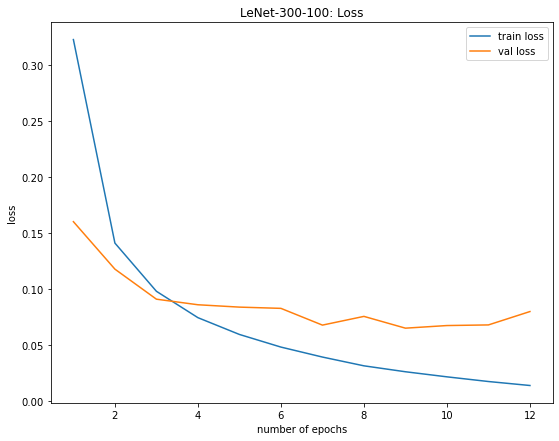

In [91]:
# Visualize losses-
plt.figure(figsize = (9, 7))

plt.plot(list(plot_loss.keys()), list(plot_loss.values()), label = 'train loss')
plt.plot(list(plot_val_loss.keys()), list(plot_val_loss.values()), label = 'val loss')

plt.title("LeNet-300-100: Loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()


In [103]:
plot_lr = {}
# plot_steps = {}

In [156]:
# for epoch in history_constant_lr.keys():
for epoch in history_warmup_and_decay_lr.keys():
    plot_lr[epoch] = history_warmup_and_decay_lr[epoch]['lr']
    # plot_steps[epoch] = history_constant_lr[epoch]['step_val']
    

In [139]:
history_time_decay_lr.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr', 'step_val'])

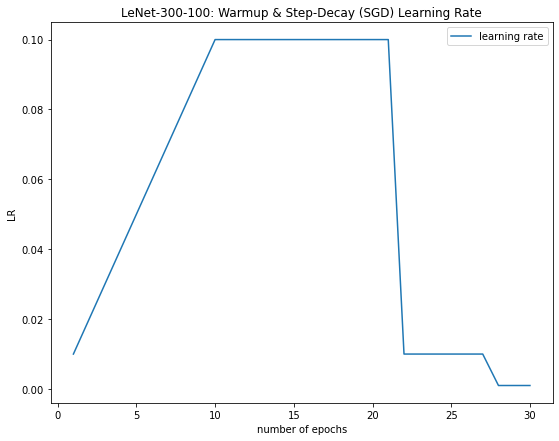

In [158]:
# Visualize accuracies-
plt.figure(figsize = (9, 7))

plt.plot(list(plot_lr.keys()), list(plot_lr.values()), label = 'learning rate')
# plt.plot(list(plot_steps.keys()), list(plot_steps.values()), label = 'step values')

# plt.title("LeNet-300-100: LR & step values")
plt.title("LeNet-300-100: Warmup & Step-Decay (SGD) Learning Rate")
plt.xlabel("number of epochs")
plt.ylabel("LR")
plt.legend(loc = 'best')
plt.show()
